<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load required Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Generate Data" data-toc-modified-id="Generate-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate Data</a></span></li><li><span><a href="#Trains" data-toc-modified-id="Trains-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trains</a></span></li><li><span><a href="#The-Infrastructure" data-toc-modified-id="The-Infrastructure-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Infrastructure</a></span><ul class="toc-item"><li><span><a href="#The-Base-Class" data-toc-modified-id="The-Base-Class-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>The Base Class</a></span></li><li><span><a href="#Depots" data-toc-modified-id="Depots-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Depots</a></span></li><li><span><a href="#Cross-Over-Points" data-toc-modified-id="Cross-Over-Points-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cross Over Points</a></span></li><li><span><a href="#Stations" data-toc-modified-id="Stations-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Stations</a></span></li></ul></li><li><span><a href="#The-Network" data-toc-modified-id="The-Network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The Network</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#System-Verification" data-toc-modified-id="System-Verification-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>System Verification</a></span><ul class="toc-item"><li><span><a href="#Reference-Simulation" data-toc-modified-id="Reference-Simulation-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Reference Simulation</a></span></li><li><span><a href="#Simulating-an-Incident" data-toc-modified-id="Simulating-an-Incident-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Simulating an Incident</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

#Load required Libraries

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import string
import random

# Uncomment below line to install simpy lib
# !pip install simpy
import simpy
import simpy.events as evt

started = []
stopped = []
passengers_travelled = 0
backlog_passengers = 0

#Generate Data

In [ ]:
# Initializing all the input constants given in the problems
dist_acceln = 4820  # Distance covered for attaining maximum speed from zero is 4820 meters.
dist_deceln = 9640  # Distance covered after slow deceleration is 9620 meters.
time_acceln = 115.7  # Time taken for accelerating from zero to maximum speed is 115.7seconds 
time_deceln = 231.4  # Time taken for decelerating to zero is 231.4seconds
MaxSpeed = 83.3  # Max Speed attained by train is 83.3metre per second


def generate_data(k):
    # Initializing all the lists which will be columns in dataframe and adding first two stations data
    Fromlist = ['London Euston', 'London Old Oak']      # list representing 'from' station
    ToList = ['London Old Oak']                         # list representing 'To' station
    Distance = [14]                                     # list representing Distance covered between stations
    RunningTime_MaxSpeed = [300]                        # list representing required time with maximum speed
    RunningTime_Acceleration = [300]                    # list representing required time while train is accelerating
    RunningTime_Deceleration = [300]                    # list representing required time while train is decelerating
    RunningTime_Acc_Deceleration = [300]
    # Generating the running time based on the number of signals
    for i in range(1, k+1):
        Dist = (round((145 / k), 2))*1000               # Dividing Total distance between London Old Oak Custom and Birmingham interchange in to equal blocks (in meters)
        Distance.append(Dist/1000)

        # Calculating time required to travel given distance as per different conditions and appending in to list
        RunningTime_MaxSpeed.append(round(Dist / MaxSpeed, 2))
        RunningTime_Acceleration.append(round(((Dist - dist_acceln) / MaxSpeed) + time_acceln, 2))
        RunningTime_Deceleration.append(round(((Dist - dist_deceln) / MaxSpeed) + time_deceln, 2))
        RunningTime_Acc_Deceleration.append(round(
            ((Dist - (dist_acceln + dist_deceln)) / MaxSpeed) + (
                    time_acceln + time_deceln),
            2))
        if i < k:
            Fromlist.append("Signal " + str(i))
            ToList.append("Signal " + str(i))
        elif i == k:
            ToList.append("Birmingham Interchange")


    # Adding data of Birmingham Interchange to Birmingham Curzon Street
    Fromlist.append("Birmingham Interchange")
    ToList.append("Birmingham Curzon Street")
    Distance.append(25.5)
    RunningTime_MaxSpeed.append(540)
    RunningTime_Acceleration.append(540)
    RunningTime_Deceleration.append(540)
    RunningTime_Acc_Deceleration.append(540)

    # creating dataframe with obtained data
    def make_complex(**kwargs):
        return [dict(zip(kwargs.keys(), a)) for a in zip(*kwargs.values())]

    data = make_complex(From=Fromlist, To=ToList, Distance=Distance, Traveltimemaxspeed=RunningTime_MaxSpeed,
                         TraveltimeAcc=RunningTime_Acceleration, TraveltimeDec=RunningTime_Deceleration,
                         TraveltimeAccdec=RunningTime_Acc_Deceleration)
    dt = pd.DataFrame(data)
    
    # Uncomment below lines to enable printing data
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #     print(frame)
    
    return dt

#Trains

In [ ]:
class Train(object):
    """
    Class for train
    """

    def __init__(self, env, i, track):
        """
        function to initialize all required parameters for new train object
        :param env: current env of simulation
        :param i: number of train
        :param track: object of line on which train object is created
        """
        self.env = env
        self.no = i
        self.track = track
        self.tracing = False
        self.passengers = 0                     # Number of passengers on the train
        self.maxPassengers = 441                # Passengers limit of train 70% of 630 i.e. capacity of 300m train

    def getNo(self):
        """
        function to get number of the train
        """
        return self.no

    def isTracing(self):
        """
        function to check tracing
        """
        return self.tracing

    def traceOn(self):
        """
        function to start tracing
        """
        self.tracing = True

    def traceOff(self):
        """
        function to stop tracing
        """
        self.tracing = False

    def process(self):
        """
        function to simulate train on the line
        """

        # defining global variables used for average travel time and total passengers travelled calculations
        global started
        global stopped
        global passengers_travelled

        # obtaining all the network nodes in existing order on the line (e.g. station, station, block, block...)
        NetNodes = self.track.getStations()
        here = NetNodes[0]
        here_req = None
        initial_speed = 0
        started.append(int(self.env.now))
        yield self.env.timeout(here.dwellTime())

        for dest in NetNodes[1:-1]:
            # get the type of current and destination nodes
            here_node = here.node_type()
            dest_node = dest.node_type()
            dest_signal = dest.getTrack().count # 1: resource taken; 0:resource free

            # Check if destination node is available to enter
            if dest_signal == 1:
              if here_node == "Station":
                print("Red signal ------------ Train {} has to wait at {} ---------------".format(self.no, here.location))
              elif here_node == "Block":
                print("Red signal ------------ Train {} has to wait at {} ---------------".format(self.no, here.from_location))

            # Insert delay for any incident introduced
            if here_node == "Station":
                if here.incident():
                    here.inc(self)
                    yield self.env.timeout(here.incidentDelay())

            # generate request for destination node
            dest_req = dest.getTrack().request()
            yield dest_req

            # Passengers get on the train as per the train capacity.
            if here_node == "Station":
                percentage_of_passenger_got_on = random.randint(1,100)
                num_on_board = self.getOn(math.ceil(int((here.num_passenger)*percentage_of_passenger_got_on)/100))
                here.num_passenger -= num_on_board
                print("Total Passengers got on the train {} at station {} : {}".format(self.no, here.location, num_on_board))
                print("----------------------------------------------------------------------")
                if here.incident():
                    here.inc(self)
                    yield self.env.timeout(here.incidentDelay())

            # departure from current node
            here.dep(self, dest)

            # Following conditions decides the time taken by train to travel from current node to destination node.
            # Depending upon the availability of next node and current speed of the train travel time is chosen.
            if here_node == "Depot":
                travel_time = dest.driveTime()

            elif here_node == "Block" and dest_node == "Block" and initial_speed == 1 and dest_signal == 0:
                travel_time = dest.timeMaxSpeed()

            elif here_node == "Block" and initial_speed == 1 and (dest_node == "Station" or dest_signal == 1):
                travel_time = dest.timeDeccln()

            elif dest_node == "Block" and dest_signal == 0 and (here_node == "Station" or initial_speed == 1):
                travel_time = dest.timeAccln()

            elif (here_node == "Station" or initial_speed == 0) and (dest_node == "Station" or dest_signal == 1):
                travel_time = dest.timeAcclnDeccln()

            # add delay of 5 seconds considering current block is released after train departs
            if (here_node == "Station") or (here_node == "Block" and dest_signal == 1):
              yield self.env.timeout(5)
            if here_req is not None:
                here.getTrack().release(here_req)

            # Add timeout as per the time taken by the train to travel to destination node
            if (here_node == "Station") or (here_node == "Block" and dest_signal == 1):
              yield self.env.timeout(travel_time - 5)
            else:
              yield self.env.timeout(travel_time)

            # train arrives at destination node
            dest.arr(self)

            # passengers get off. random percentage of passengers travelling in train get off at destination station.
            if dest_node == "Station" and self.passengers != 0:
                yield self.env.timeout(dest.dwellTime())
                percentage_of_passenger_got_off = random.randint(1,100)
                num_got_off = self.getOff(math.ceil(int((self.passengers)*percentage_of_passenger_got_off)/100))
                dest.num_passenger += num_got_off
                print("Total Passengers got off the train {} at station {} : {}".format(self.no, dest.location, num_got_off))
                print("----------------------------------------------------------------------")
                passengers_travelled += num_got_off
                initial_speed = 0
            else:
                initial_speed = 1

            # change the speed of train to 0 if destination node was not available
            if dest_signal == 1:
                initial_speed = 0

            # change current node as destination node and request as the train is at destination node now
            here = dest
            here_req = dest_req

        # The train is now in the last station and has waited there already long
        # enough for all passengers to disembark. The destination is now the depot.
        depot = NetNodes[-1]

        # Assuming that there is always space in the depot,
        # the train leaves for the depot:
        here.dep(self, depot)

        # Once the train has completely left the last station ('here'),
        # the train will release the track of the last station.
        # We assume that the train has left the station after 10 secs
        # yield self.env.timeout(10)
        if here_req != None:
            here.getTrack().release(here_req)

        # the train proceeds to drive into the depot
        yield self.env.timeout(depot.driveTime())

        # The train arrives at the depot and "checks in"
        depot.arr(self)
        # Capture the time at which train reached last station
        stopped.append(int(self.env.now))

    def getOff(self, num):
        """
        function to handle get off functionality of train
        :param num: number of passengers wants to get off
        :return: number of passengers get off
        """
        if self.passengers >= num:
            print(f"{num:d} passengers got off")
            self.passengers -= num
        else:
            num = self.passengers
            print(f"train is empty - only {num:d} passengers got off")
            self.passengers = 0
        return num

    def getOn(self, num):
        """
        function to handle get on functionality of train 
        :param num: number of passengers wants to get on the train
        :return: number of passengers get on
        """
        if (self.maxPassengers is None) or (self.passengers + num <= self.maxPassengers):
            print(f"{num:d} passengers got on")
            self.passengers += num
        else:
            num = self.maxPassengers - self.passengers
            print(f"train is full - only {num:d} passengers got on")
            self.passengers = self.maxPassengers
        return num


# The Infrastructure

The Infrastructure consists of Depots, Stations, and Blocks.
A parent class named 'NetworkNodes' is used for infrastructure and above mentioned are its subclasses. These subclasses such as station, depot will inherit functions and attributes of parent class NetworkNodes.

A Track consists of a sequence of NetworkNodes. A track begins in a Depot and ends in a Depot. While these are physically the same depots we use two instances of the class Depot, one at the beginning and one at the end of the track.

A linear track is made up of depot, starting 2 stations (London Euston, London Old Oak), then blocks as per decided number, then last 2 stations (Birmingham Interchange and Birmingham Curzon Street), and depot at the end.

All these network nodes work as resorces with capacity = 1, allowing only one train to share it at a time.

## NetworkNode (base class)

In [ ]:
class NetworkNode:
    """
    Class defining infrastructure. This will be parent class for all other classes station, depot and block
    """

    def __init__(self, env, location):
        """
        function initializing a network node.
        :param env: simulation environment created by Network
        :param location: location name of the node station name/depot name/ destination name of a block
        """
        self.env = env
        self.location = location
        self.incidents = []
        self.tracing = True

    def setLine(self, line):
        """
        function to set the line object for the network node on which it resides
        :param line: line object on which networknode resides
        """
        self.line = line

    def isTracing(self):
        """
        function to check tracing
        """
        return self.tracing

    def traceOn(self):
        """
        function to start tracing
        """
        self.tracing = True

    def traceOff(self):
        """
        function to stop tracing
        """
        self.tracing = False

    def trace_prefix(self, train):
        """
        function to set prefix for simulation display. Including time and train
        :param train: train object
        :return: trace prefix
        """
        return f"{formattedSystemTime(self.env.now):s} " \
               f"[Train {train.getNo():2d}]"

    def arr(self, train):
        """
        function to handle arrival of train at network node
        :param train: train object arriving at network node
        """
        if self.isTracing() or self.line.isTracing() or train.isTracing():
            print(f"{self.trace_prefix(train):s} arr {self.loc():s}")

    def dep(self, train, dest):
        """
        function to handle departure of train to network node
        :param train: train object arriving at network node
        """
        if self.isTracing() or \
                (self.line != None and self.line.isTracing()) or \
                train.isTracing():
            print(f"{self.trace_prefix(train):s} dep {self.loc():s} for {dest.loc():s}")

    def node_type(self):
        """
        function to fetch class name of network node. it gives network node type
        :return: network node type
        """
        return type(self).__name__

    def inc(self, train):
        """
        function to handle incident delays at network node of given train
        :param train: train object having incident delays
        """
        if self.isTracing() or self.line.isTracing() or train.isTracing():
            delay = self.incidentDelay()
            message = f"expected delay {formattedSystemTime(delay):s}" \
                if delay > 0 else "cleared"
            print(f"{self.trace_prefix(train):s} incident at {self.loc():s} {message:s}")

    def registerIncident(self, incident):
        """
        function to register the incident
        :param incident: incident object created for network node
        """
        self.incidents += [incident]

    def incident(self):
        """
        function checks if there is currently an incident in progress.
        :return: True or False as per the incident situation
        """
        for inc in self.incidents:
            if inc.active(self.env.now):
                return True
        return False

    def incidentDelay(self):
        """
        function to give time estimation of incident
        :return: time estimation of incident
        """
        stopTime = 0
        for incident in self.incidents:
            if incident.active(self.env.now):
                stopTime = max(stopTime, incident.stopTime())
        res = 0 if stopTime == 0 else stopTime - self.env.now
        return res

    def getTrack(self):
        """
        function to get track object on network node
        """
        pass

    def loc(self):
        """
        function to get location name of network node
        """
        pass

    def track_name(self):
        """
        function to get track name for network node
        """
        pass


## Depot

In [ ]:
class Depot(NetworkNode):
    """
    Class for depot
    """
    def __init__(self, env, location):
        """
        function initializing depot
        """
        super().__init__(env, location)
        self.env = env
        self.location = location
        self.tracks = None

    def initialise(self, capacity):
        """
        function to create resource for depot
        :param capacity: capacity of depot, allowing number of trains accordingly
        """
        self.tracks = simpy.Container(self.env, capacity, init=capacity)

    def driveTime(self):
        """
        function to get drive time
        :return: return 0 assuming no time required for travelling from depot to station
        """
        return 0

    # the minimum dwell time is to allow for a proper break for the driver
    def dwellTime(self):
        """
        function to get dwell time at depot
        :return: return 0 assuming no dwell time at depot
        """
        return 0

    def dep(self, train, dest):
        """
        function to implement departure from depot to destination node
        :param train: train object 
        :param dest: destination node object
        """
        super().dep(train, dest)

    def arr(self, train):
        """
        function puts train back into depot
        :param train: train object
        """
        super().arr(train)

    def getTrack(self):
        """
        function to get track object of depot
        :return: None
        """
        return None  ##return self

    def loc(self):
        """
        function to get depot name
        :return: depot name
        """
        return "Depot " + self.location

## Station

In [ ]:
class Station(NetworkNode):
    """
    Station class
    """
    def __init__(self, env, location, num_passenger):
        """
        function to initialize station object
        :param env: simulation environment
        :param location: station name / location
        :param num_passenger: Number of passengers at station
        """
        super().__init__(env, location)
        self.env=env
        self.location=location
        self.num_passenger = num_passenger
        self.track=simpy.Resource(env, capacity=1)

        # set time for travel according to the type and sequence of station
        dd = pd.DataFrame(dt[dt['To'] == location])
        if len(dd) == 0:
            self.drive_time = 0
            self.off_peak_dwell_time = 120
            self.peak_dwell_time = 120
        else:
            self.time_accln = int(dd.iloc[0].at['TraveltimeAcc'])
            self.time_max_speed = int(dd.iloc[0].at['Traveltimemaxspeed'])
            self.time_deccln = int(dd.iloc[0].at['TraveltimeDec'])
            self.time_accln_deccln = int(dd.iloc[0].at['TraveltimeAccdec'])
            self.off_peak_dwell_time = 120
            self.peak_dwell_time = 120

    def driveTime(self):
        """
        function to get dwell time
        :return: returns drive time
        """
        return self.drive_time
    
    def dwellTime(self):
        """
        function to get dwell time
        :return: returns 0, dwell time functionality not considered as average time delay is given in question
        """
        return 0

    def timeMaxSpeed(self):
        """
        function to get time taken to travel with max speed
        :return: time taken to travel with max speed
        """
        return self.time_max_speed

    def timeDeccln(self):
        """
        function to get time taken to travel with deceleration
        :return: time taken to travel with deceleration
        """
        return self.time_deccln

    def timeAccln(self):
        """
        function to get time taken to travel with acceleration
        :return: time taken to travel with acceleration
        """
        return self.time_deccln

    def timeAcclnDeccln(self):
        """
        function to get time taken to travel with acceleration and deceleration
        :return: time taken to travel with acceleration and deceleration
        """
        return self.time_accln_deccln

    def getTrack(self):
        """
        function to get track object on which station resides
        :return: track object
        """
        return self.track

    def loc(self):
        """
        function to get station name / location
        :return:
        """
        return self.location

## Block

In [ ]:
class Block(NetworkNode):
    """
    Block class
    """
    def __init__(self, env, from_to_list):
        """
        function to initialize block object
        :param env: simulation environment
        :param location: block's name / location
        """
        super().__init__(env, from_to_list[1])
        self.env = env
        self.from_location = from_to_list[0]
        self.to_location = from_to_list[1]
        self.track = simpy.Resource(env, capacity=1)

        # set time for travel for every possible scenario
        dd=pd.DataFrame(dt[dt['To']==self.to_location])
        if len(dd)==0:
            # This node is the first node of a track after CrossOver of direction
            # or when coming out of the depot
            self.drive_time=30
        else:
            self.time_accln = int(dd.iloc[0].at['TraveltimeAcc'])
            self.time_max_speed = int(dd.iloc[0].at['Traveltimemaxspeed'])
            self.time_deccln = int(dd.iloc[0].at['TraveltimeDec'])
            self.time_accln_deccln = int(dd.iloc[0].at['TraveltimeAccdec'])

    def getTrack(self):
        """
        function to get track object on which station resides
        :return: track object
        """
        return self.track

    def loc(self):
        """
        function to get station name / location
        :return:
        """
        return self.location

    def timeMaxSpeed(self):
        """
        function to get time taken to travel with max speed
        :return: time taken to travel with max speed
        """
        return self.time_max_speed

    def timeDeccln(self):
        """
        function to get time taken to travel with deceleration
        :return: time taken to travel with deceleration
        """
        return self.time_deccln

    def timeAccln(self):
        """
        function to get time taken to travel with acceleration
        :return: time taken to travel with acceleration
        """
        return self.time_deccln

    def timeAcclnDeccln(self):
        """
        function to get time taken to travel with acceleration and deceleration
        :return: time taken to travel with acceleration and deceleration
        """
        return self.time_accln_deccln


# The Network

Line class for track

In [ ]:
class Line(object):
    """
    Line class for track
    """
    def __init__(self, env, network, depot, first_stations, last_stations, block):
        """
        function for initializing line object with parameters
        :param env: simulation environment
        :param network: Network object
        :param depot: list of depot object
        :param first_stations: list of objects of first two stations  
        :param last_stations: list of objects of last two stations
        :param block: list of objects of all blocks
        """
        self.env = env
        self.network = network
        self.depot = depot
        self.block = block
        self.stations = [depot] + first_stations + block + last_stations + [depot]
        self.tracing = False
        self.tracingTrains = False
        self.tracingTrainNo = None
        for s in self.stations:
            s.setLine(self)

    def isTracing(self):
        """
        function to check tracing status
        :return: True / False for tracing
        """
        return self.network.isTracing() or self.tracing

    def traceOn(self, loc=None, train=None):
        """
        function to start tracing line
        :param loc: location to trace
        :param train: train to trace
        """
        if loc == None and train == None:
            self.tracing = True
        else:
            for s in self.stations:
                if s.loc() == loc:
                    s.traceOn()
            if train != None:
                self.tracingTrains = True
                self.tracingTrainNo = train

    def traceOff(self, loc=None, train=None):
        """
        function to stop tracing line
        :param loc: location to stop tracing
        :param train: train to stop tracing
        """
        if loc == None and train == None:
            self.tracing = False
        else:
            for s in self.stations:
                if s.loc() == loc:
                    s.traceOff()
            if train != None:
                self.tracingTrains = False
                self.tracingTrainNo = train

    def getNetwork(self):
        """
        function o get network object of line
        :return: network object
        """
        return self.network

    def getStations(self):
        """
        function to get list of objects of station
        :return: list of objects of station
        """
        return self.stations

    def setTiming(self, start, stop, timing):
        """
        function to set simulation timings 
        :param start: start time 
        :param stop: stop time
        :param timing: time difference between two consecutive trains
        """
        self.start = start
        self.stop = stop
        self.timing = timing
        self.depot.initialise((self.stop - self.start) // self.timing + 2)

    def process(self):
        """
        function to simulate all trains on the line  
        """
        yield self.env.timeout(self.start - self.env.now)
        for i in range(int(math.ceil((self.stop - self.start) / self.timing))):
            t = Train(self.env, i, self)
            if self.tracingTrains and self.tracingTrainNo == i:
                t.traceOn()
            self.env.process(t.process())
            yield self.env.timeout(self.timing) 

Functions to generate station objects and passenegers on these stations with poisson distribution. 

In [ ]:
def poisson_dist():
    """
    function to generate passengers for stations using poisson distribution
    :return: list of passengers distribution
    """
    dis_passenger = np.random.poisson(7000, 10)
    return dis_passenger

def all_first_stations(env):
    """
    function to generate first 2 stations objects
    :return: stations objects list
    """
    stations=dt['From'].to_list()[0:2]
    num_passengers = poisson_dist()
    Stations = []
    for i in range(len(stations)):
      Stations.append(Station(env, stations[i], num_passengers[i]))
    return Stations

def all_last_stations(env):
    """
    function to generate last 2 stations objects
    :return: stations objects list
    """
    stations=dt['To'].to_list()[-2:]
    num_passengers = [7000, 0]
    Stations = []
    for i in range(len(stations)):
      Stations.append(Station(env, stations[i], num_passengers[i]))
    return Stations


Function to generate blocks

In [ ]:
def allBlocks(env):
    """
    function to generate objects of blocks 
    :return: list of block s objects
    """
    blocks=[]
    from_blocks=dt['From'].to_list()
    to_blocks=dt['To'].to_list()
    for i in range(1,len(from_blocks)-1):
        blocks+=[[from_blocks[i],to_blocks[i]]]
    return [ Block(env, b) for b in blocks ]

In [ ]:
def Tracks(env, network):
    """
    function to create line object
    :return: line object
    """
    first_stations = all_first_stations(env) 
    last_stations = all_last_stations(env)
    block = allBlocks(env)
    depot=Depot(env, first_stations[0].loc())
    line=Line(env, network, depot, first_stations, last_stations, block)
        
    return line


Network class

In [ ]:
class Network(object):
    """
    Network class
    """

    def __init__(self, start, stop, timing):
        """
        function to initialize Network
        :param start: start time
        :param stop: stop time
        :param timing: time difference between 2 consecutive trains
        """
        self.env = simpy.Environment()
        self.track = Tracks(self.env, self)
        self.start = parseTime(start)
        self.stop = parseTime(stop)
        self.timing = timing
        self.tracing = False

    def isTracing(self):
        """
        function to check if tracing is on
        :return: True / False
        """
        return self.tracing

    def traceOn(self, loc=None, train=None, start=None, stop=None):
        """
        function to start tracing line
        :param loc: location to trace
        :param train: train to trace
        :param start: start time for tracing
        :param stop: stop time for tracing
        """
        if loc == None and train == None:
            Trace(start=start, stop=stop)
            self.tracing = True
        else:
            Trace(start=start, stop=stop)
            self.track.traceOn(loc=loc, train=train)

    def traceOff(self, loc=None, train=None):
        """
        function to stop tracing line
        :param loc: location to trace
        :param train: train to trace
        """
        if loc == None and train == None:
            Trace = Trace()
            self.tracing = False
        else:
            Trace = Trace()
            self.track.traceOff(loc=loc, train=train)

    def incident(self, start, stop, loc=None):
        """
        function to create incident 
        :param start: incident start time
        :param stop: incident stop time
        :param loc: incident location
        :return: 
        """
        tracks = []
        for t in self.track.getStations():
            if loc == None or t.loc() == loc:
                tracks += [t]
        incident = Incident(start, stop)
        for t in tracks:
            t.registerIncident(incident)

    def process(self):
        """
        function to run simulation
        """
        self.track.setTiming(self.start, self.stop, self.timing)
        yield self.env.timeout(self.start - self.env.now)  # the line starts operating at 6am
        self.env.process(self.track.process())

    def runSimulation(self):
        """
        function to start simulation process and run environment
        """
        self.env.process(self.process())
        self.env.run()

# Utilities

In [ ]:
def formattedSystemTime(t):
    """
    function to format the system time
    :return: formated time
    """
    t = int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"

def parseTime(s):
    """
    function to convert seconds into hrs:mins:secs format
    :return: parsed time
    """
    if isinstance(s, str):
        parts=s.split(':')
        if len(parts)>=2:
            hours=int(parts[0])
            minutes=int(parts[1])
            seconds=0 if len(parts)==2 else int(parts[2])
            return 3600*hours+60*minutes+seconds
    # any wrong formats will be passed through and may cause 
    # an error at a later stage
    return s

In [ ]:
class Incident:
    """
    Incident class
    """

    def __init__(self, start, stop):
        """
        function to initialize the incident 
        :param start: incident start time
        :param stop: incident stop time
        """
        self.start = parseTime(start)
        self.stop = parseTime(stop)

    def active(self, systime):
        """
        function to check status of incident
        :param systime: system time 
        :return: 
        """
        return self.start <= systime and systime <= self.stop

    def startTime(self):
        """
        function to get start time
        :return: start time
        """
        return self.start

    def stopTime(self):
        """
        function to get stop time
        :return: stop time
        """
        return self.stop

In [ ]:
class Trace:
    """
    Trace class
    """

    def __init__(self, start=None, stop=None):
        """
        function to initialize the trace incident 
        :param start: start time
        :param stop: stop time
        """
        Trace.__start = parseTime(start)
        Trace.__stop = parseTime(stop)

    def notTracing(systime):
        """
        surpressing function and not an activating function
        :return: True / False
        """
        if Trace.__start != None and systime < Trace.__start:
            return True
        if Trace.__stop != None and systime > Trace.__stop:
            return True
        return False

# System Verification

Verification always uses selective traces. Therefore evatuation of simulation funtionality is done by Running simulation for 10 trains/ hour and 10 signal blocks

In [ ]:
dt = generate_data(10)
print("-------------------------Data frame---------------------------")
print(dt)
print("----------------------Train Simulation------------------------")
network=Network("06:00", "07:00", 360)
network.traceOn(start="06:00", stop="07:00")
network.runSimulation()

-------------------------Data frame---------------------------
                      From  ... TraveltimeAccdec
0            London Euston  ...           300.00
1           London Old Oak  ...           347.58
2                 Signal 1  ...           347.58
3                 Signal 2  ...           347.58
4                 Signal 3  ...           347.58
5                 Signal 4  ...           347.58
6                 Signal 5  ...           347.58
7                 Signal 6  ...           347.58
8                 Signal 7  ...           347.58
9                 Signal 8  ...           347.58
10                Signal 9  ...           347.58
11  Birmingham Interchange  ...           540.00

[12 rows x 7 columns]
----------------------Train Simulation------------------------
06:00:00 [Train  0] dep Depot London Euston for London Euston
06:00:00 [Train  0] arr London Euston
train is full - only 441 passengers got on
Total Passengers got on the train 0 at station London Euston : 441
----

#Optimization 

##Data generation for optimization

In [ ]:
no_of_trains_list = [3,4,5,6,8,10]                          # number of trains per hour 
no_of_signal_blocks_list = [2,3,4,5,6,7,8,9,10,11,12,13,14]
N=[]
K=[]
aryavgtime=[]
throughput=[]
global backlog_passengers

# Runnning simulation for all given combination of no_of_trains and no_of_signal_blocks
for k in no_of_signal_blocks_list:
    # generating data for no_of_signal_blocks 
    dt = generate_data(k)
    
    for n in no_of_trains_list:
        print(str(k)+"  "+str(n))
        print("-------------------------------------------------------------------------------")
        Timetakenbetweentrains= 3600/n
        # simulating network
        network=Network("06:00", "10:00", Timetakenbetweentrains)
        network.runSimulation()
        
        # Average travelling time calculation 
        totaltime = list(map(int.__sub__, stopped, started))
        avgtime = (sum(totaltime)/len(totaltime))+(0.5*60/n)
        print("Average traelling time with {} trains per hour and {} blocks : {}".format(n, k, avgtime))
        
        # Total time of simulation
        Total_simulation_time = stopped[-1] - started[0]
        print("Total simulation time in seconds {}".format(Total_simulation_time)) 
        
        # Total number of passengers travelled
        actual_passengers_travelled=passengers_travelled-backlog_passengers
        backlog_passengers=passengers_travelled
        print("Total passengers travelled {}".format(actual_passengers_travelled))
        
        # Calculating throughput passenger travelling / hour
        Throughput_of_passengers = (actual_passengers_travelled*3600)/Total_simulation_time 
        print("Throughput of passengers : {}".format(Throughput_of_passengers))
        
        aryavgtime.append(round(avgtime, 2))
        N.append(n)
        K.append(k)
        throughput.append(round(Throughput_of_passengers, 2))

# resetting global parameters
started = []
stopped = []
passengers_travelled = 0

Streaming output truncated to the last 5000 lines.
08:45:00 [Train 16] arr London Old Oak
54 passengers got off
Total Passengers got off the train 16 at station London Old Oak : 54
----------------------------------------------------------------------
train is full - only 345 passengers got on
Total Passengers got on the train 16 at station London Old Oak : 345
----------------------------------------------------------------------
08:45:00 [Train 16] dep London Old Oak for Signal 1
08:45:12 [Train 15] arr Signal 4
08:45:12 [Train 15] dep Signal 4 for Signal 5
08:45:32 [Train 14] arr Signal 9
08:45:32 [Train 14] dep Signal 9 for Signal 10
08:45:52 [Train 13] arr Birmingham Interchange
08:45:52 [Train 13] dep Birmingham Interchange for Birmingham Interchange
08:47:16 [Train 15] arr Signal 5
08:47:16 [Train 15] dep Signal 5 for Signal 6
08:47:36 [Train 14] arr Signal 10
08:47:36 [Train 14] dep Signal 10 for Signal 11
08:48:52 [Train 12] arr Birmingham Curzon Street
397 passengers got off


In [ ]:

df = pd.DataFrame(
    {'N1': N,
     'K1': K,
     'avgtime':aryavgtime,
     'throughput':throughput
    })
print(df['avgtime'].min())
print(df['throughput'].max())

3742.91
3491.72


In [ ]:
from sklearn import linear_model
import statsmodels.api as sm
predictors_NnK = pd.DataFrame(
    {'N1': N,
     'K1': K
    })
avg_travel_time_Response_variable=pd.DataFrame(
    {'avgtime':aryavgtime
    })
predictors_NnK=sm.add_constant(predictors_NnK)
avg_travel_time_model = sm.OLS(avg_travel_time_Response_variable,predictors_NnK).fit()
avg_travel_time_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgtime   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     37.35
Date:                Mon, 11 May 2020   Prob (F-statistic):           5.54e-12
Time:                        03:37:34   Log-Likelihood:                -645.18
No. Observations:                  78   AIC:                             1296.
Df Residuals:                      75   BIC:                             1303.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8149.5583    377.354     21.597      0.000    7397.831    8901.286
N1            27.2741     45.906      0.594      0.554     -64.175     118.723
K1          -251.8285     29.206     -8.623      0.000    -310.009    -193.648
==============================================================================
Omnibus:                       32.215   Durbin-Watson:                   0.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.840
Skew:                          -1.085   Prob(JB):                     2.61e-31
Kurtosis:                       9.215   Cond. No.                         36.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
predictors_NnK = pd.DataFrame(
    {'N1': N,
     'K1': K
    })
throughput_Response_variable=pd.DataFrame(
    {'throughput':throughput
    })
predictors_NnK=sm.add_constant(predictors_NnK)
throughput_model = sm.OLS(throughput_Response_variable,predictors_NnK).fit()
throughput_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             throughput   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     21.12
Date:                Mon, 11 May 2020   Prob (F-statistic):           5.30e-08
Time:                        03:37:51   Log-Likelihood:                -582.93
No. Observations:                  78   AIC:                             1172.
Df Residuals:                      75   BIC:                             1179.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1481.5185    169.879      8.721      0.000    1143.102    1819.935
N1           119.5941     20.666      5.787      0.000      78.425     160.763
K1            38.8929     13.148      2.958      0.004      12.701      65.085
==============================================================================
Omnibus:                        3.002   Durbin-Watson:                   1.184
Prob(Omnibus):                  0.223   Jarque-Bera (JB):                2.749
Skew:                           0.111   Prob(JB):                        0.253
Kurtosis:                       3.893   Cond. No.                         36.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import random

In [ ]:
def f_average_travelling_time(N,K):
    # Function obtained using linear equition of obtained data
    result = 8149 + 27*N - 252*K
    return result

def f_throughput_passenger(N,K):
    # Function obtained using linear equition of obtained data
    result = 119*N + 39*K + 1481
    return result

In [ ]:
random.seed(0)
def monte_carlo_min(n, xmin=3, xmax=10, ymin=2, ymax=14):
    N = [ random.randint(xmin, xmax) for i in range(n)]
    K = [ random.randint(ymin, ymax) for i in range(n)]
    xp = [ N[0] ]
    yp = [ K[0] ]
    fmin = f_average_travelling_time(xp[0], yp[0])
    for i in range(1, len(N)):
        fi = f_average_travelling_time(N[i], K[i])
        if fi < fmin:
            xp += [N[i]]
            yp += [K[i]]
            fmin = fi
   
    xs = np.linspace(xmin, xmax, 100)
    ys = np.linspace(ymin, ymax, 100)
    xx, yy = np.meshgrid(xs, ys)
    z=f_average_travelling_time(xx, yy)
   
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(xs, ys, z, 100)
    fig.colorbar(cs, ax=ax)
   
    plt.scatter(N, K, c='red', marker='.')
    plt.plot(xp, yp, c='red')
    return len(xp), xp[-1], yp[-1], f_average_travelling_time(xp[-1], yp[-1])

In [ ]:
random.seed(0)
def monte_carlo_max(n, xmin=3, xmax=10, ymin=2, ymax=14):
    """
    function to find maximum value of function for given values of x and y
    """
    N = [ random.randint(xmin, xmax) for i in range(n)]
    K = [ random.randint(ymin, ymax) for i in range(n)]
    xp = [ N[0] ]
    yp = [ K[0] ]
    fmax = f_throughput_passenger(xp[0], yp[0])
    for i in range(1, len(N)):
        fi = f_throughput_passenger(N[i], K[i])
        if fi > fmax:
            xp += [N[i]]
            yp += [K[i]]
            fmax = fi
   
    xs = np.linspace(xmin, xmax, 100)
    ys = np.linspace(ymin, ymax, 100)
    xx, yy = np.meshgrid(xs, ys)
    z=f_throughput_passenger(xx, yy)
   
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(xs, ys, z, 100)
    fig.colorbar(cs, ax=ax)
   
    plt.scatter(N, K, c='red', marker='.')
    plt.plot(xp, yp, c='red')
    return len(xp), xp[-1], yp[-1], f_throughput_passenger(xp[-1], yp[-1])

(6, 4, 14, 4729)

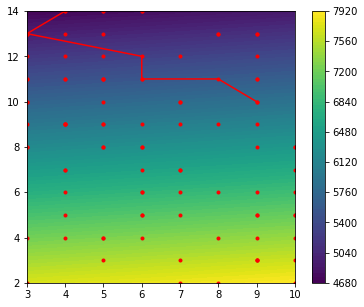

In [ ]:
random.seed(41)
monte_carlo_min(100)


(4, 10, 14, 3332)

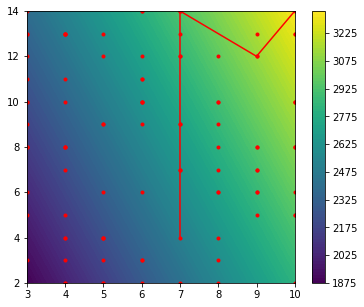

In [ ]:
random.seed(23)
monte_carlo_max(100)